Data Loaded: 20000 images, 10 classes


C:\Users\Hrutik Burde\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 216s 510ms/step - accuracy: 0.8055 - loss: 0.6289 - val_accuracy: 0.1000 - val_loss: 8.6851
Epoch 2/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 104s 259ms/step - accuracy: 0.9767 - loss: 0.0760 - val_accuracy: 0.9956 - val_loss: 0.0169
Epoch 3/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 122s 209ms/step - accuracy: 0.9906 - loss: 0.0340 - val_accuracy: 0.9975 - val_loss: 0.0166
Epoch 4/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 85s 212ms/step - accuracy: 0.9907 - loss: 0.0282 - val_accuracy: 0.9422 - val_loss: 0.1436
Epoch 5/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 83s 208ms/step - accuracy: 0.9929 - loss: 0.0234 - val_accuracy: 0.9991 - val_loss: 0.0057
Epoch 6/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 82s 205ms/step - accuracy: 0.9952 - loss: 0.0174 - val_accuracy: 0.9997 - val_loss: 0.0027
Epoch 7/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 143s 208ms/step - accuracy: 0.9943 - loss: 0.0206 - val_accuracy: 0.9850 - val_loss: 0.0502
Epoch 8/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 86s 215ms/step - accuracy: 0.9949 - los

125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 1.0000 - loss: 1.3971e-04
Test Accuracy: 1.0000


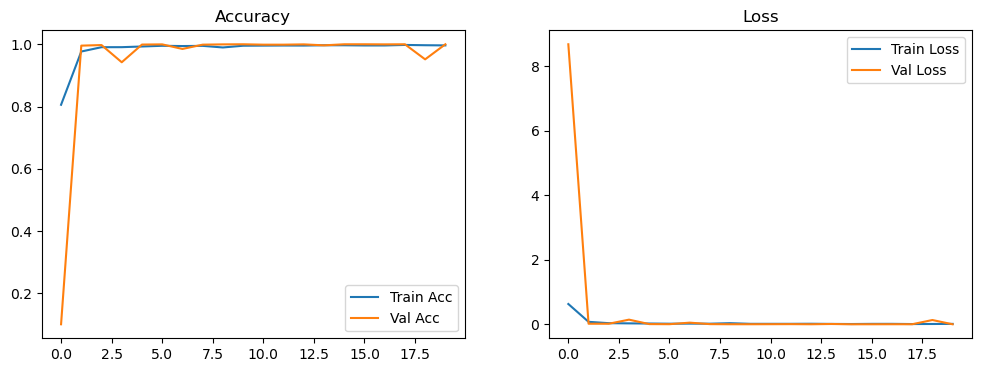

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
Predicted: 01_palm | Confidence: 96.45%


In [1]:
# ==============================
# Hand Gesture Recognition
"""Task 4 Develop a hand gesture recognition model that can accurately identify and
classify different hand gestures from image or video data, enabling intuitive human-computer interaction and gesture-based control systems."""
# ==============================

# Install packages if not installed
!pip install tensorflow opencv-python matplotlib scikit-learn Pillow --quiet

# Imports

import os
import cv2
import numpy as np
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from PIL import Image as PILImage
import time

# Data Preprocessing Class

class DataPreprocessor:
    def __init__(self, zip_path="archive.zip", extract_to="leapGestRecog", img_size=(64,64)):
        self.img_size = img_size
        self.extract_to = extract_to

        # Unzip dataset if not exists
        if not os.path.exists(extract_to):
            print("Extracting dataset...")
            with ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall()
        self.data_dir = extract_to

        # Get classes
        self.classes = self._get_classes()
        self.class_mapping = {cls: idx for idx, cls in enumerate(self.classes)}

    def _get_classes(self):
        subject_dirs = [d for d in os.listdir(self.data_dir) 
                        if os.path.isdir(os.path.join(self.data_dir, d))]
        if not subject_dirs:
            raise ValueError("No subject directories found in dataset!")
        first_subject = subject_dirs[0]
        classes = [d for d in os.listdir(os.path.join(self.data_dir, first_subject)) 
                   if os.path.isdir(os.path.join(self.data_dir, first_subject, d))]
        return sorted(classes)

    def load_and_preprocess(self):
        images = []
        labels = []

        for subject in os.listdir(self.data_dir):
            subject_path = os.path.join(self.data_dir, subject)
            if not os.path.isdir(subject_path):
                continue
            for gesture_class in self.classes:
                gesture_path = os.path.join(subject_path, gesture_class)
                if not os.path.isdir(gesture_path):
                    continue
                for img_name in os.listdir(gesture_path):
                    if img_name.endswith(('.png','.jpg','.jpeg')):
                        img_path = os.path.join(gesture_path, img_name)
                        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                        if img is None:
                            continue
                        img = cv2.resize(img, self.img_size)
                        img = img / 255.0
                        images.append(img)
                        labels.append(self.class_mapping[gesture_class])

        X = np.array(images).reshape(-1, self.img_size[0], self.img_size[1], 1)
        y = to_categorical(np.array(labels), num_classes=len(self.classes))
        return X, y

    def split_data(self, X, y, test_size=0.2, val_size=0.2):
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, y, test_size=test_size, stratify=y.argmax(axis=1), random_state=42
        )
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val, test_size=val_size, stratify=y_train_val.argmax(axis=1), random_state=42
        )
        return X_train, X_val, X_test, y_train, y_val, y_test

    def preprocess_single_image(self, image):
        if len(image.shape)==3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, self.img_size)
        image = image / 255.0
        return image.reshape(1, self.img_size[0], self.img_size[1], 1)

# CNN Model Function

def create_model(input_shape, num_classes):
    model = Sequential()
    # 1st Conv Block
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    # 2nd Conv Block
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    # 3rd Conv Block
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    # Dense layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Load data

preprocessor = DataPreprocessor(zip_path="archive.zip")
X, y = preprocessor.load_and_preprocess()
X_train, X_val, X_test, y_train, y_val, y_test = preprocessor.split_data(X, y)

print(f"Data Loaded: {X.shape[0]} images, {len(preprocessor.classes)} classes")

# Create & Train model

model = create_model(input_shape=X_train.shape[1:], num_classes=len(preprocessor.classes))
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

# Save model
os.makedirs("models", exist_ok=True)
model.save("models/best_model.h5")

# Evaluate & Plot

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title("Accuracy")
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title("Loss")
plt.show()

# Image Prediction Function

def predict_image(image_path):
    img = cv2.imread(image_path)
    processed = preprocessor.preprocess_single_image(img)
    pred = model.predict(processed)[0]
    class_name = preprocessor.classes[np.argmax(pred)]
    confidence = float(pred.max())
    print(f"Predicted: {class_name} | Confidence: {confidence:.2%}")

# Real-time Webcam Prediction

def predict_webcam():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Cannot open webcam")
        return
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        processed = preprocessor.preprocess_single_image(frame)
        pred = model.predict(processed)[0]
        class_name = preprocessor.classes[np.argmax(pred)]
        confidence = float(pred.max())
        cv2.putText(frame, f"{class_name} ({confidence:.2%})", (10,30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
        cv2.imshow("Webcam Prediction - Press 'q' to quit", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

# ==============================
# USAGE EXAMPLES
# ==============================
# 1. Predict single image:
predict_image("leapGestRecog/00/01_palm/frame_00_01_0001.png")

# 2. Run webcam prediction:

# predict_webcam()